# IMPORTING MODULES

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# LOADING DATA

In [2]:
df = pd.read_csv("C:/Users/ac/OneDrive/Desktop/Projects/Project 8/salary.csv")


<IPython.core.display.Javascript object>

# BASIC INFORMATION GAINING

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
df.shape

(32561, 15)

In [7]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

In [8]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

In [9]:
df.duplicated().sum()

24

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
# Unique values

for ele in df.columns:
    if df[ele].dtypes!="int64":
        print("{} \n: {}".format(ele, df[ele].unique()))
        print("="*50)

workclass 
: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
education 
: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
marital-status 
: [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation 
: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
relationship 
: [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
race 
: [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
sex 
: [' Male' ' Female']
native-country 
: [' United-States' ' Cub

We got some missing values here which are denoted by a question mark "?", will deal with those in data preprocessing phase.

# EDA (Exploratory Data Analysis)

 <=50K    24698
 >50K      7839
Name: salary, dtype: int64


<AxesSubplot:xlabel='salary', ylabel='count'>

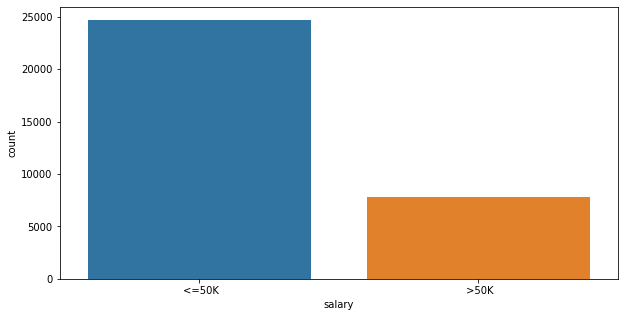

In [12]:
fig = plt.figure(figsize=(10,5))
print(df["salary"].value_counts())
sns.countplot(data = df, x="salary")

Our data is imbalance, as we can see almost 76% of the data have value "<=50K" and 24% of data have value ">50K". Will use SMOTE to balance our dataset. 

## Dominating Workclass

<AxesSubplot:xlabel='workclass', ylabel='count'>

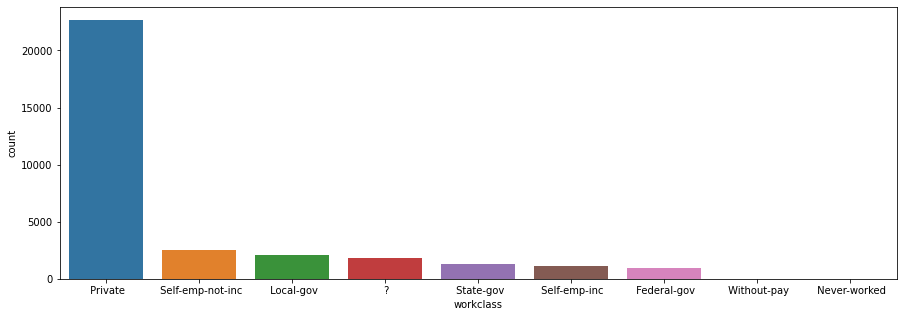

In [13]:
fig = plt.figure(figsize=(15,5))
sns.countplot(data = df, x='workclass', order=df["workclass"].value_counts().index)

Private sector plays an important role.

## Workclass vs Salary

<AxesSubplot:xlabel='workclass', ylabel='count'>

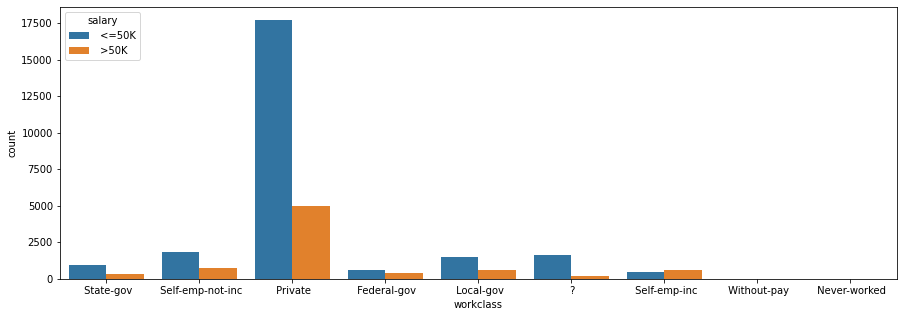

In [14]:
fig = plt.figure(figsize=(15,5))
sns.countplot(data = df, x='workclass', hue="salary")

## Occupation

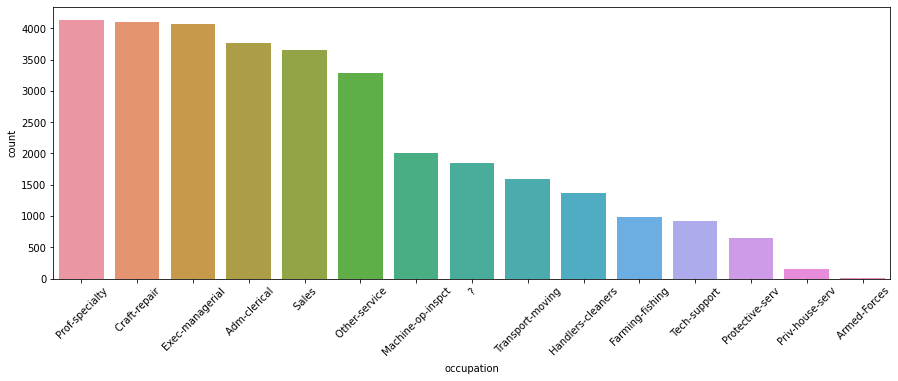

In [15]:
fig = plt.figure(figsize=(15,5))
g = sns.countplot(data = df, x='occupation', order=df["occupation"].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
plt.show()

## Education vs Salary

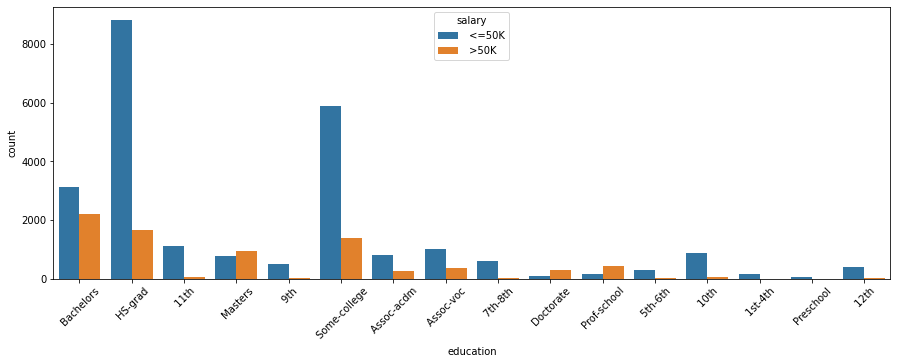

In [16]:
fig = plt.figure(figsize=(15,5))
g = sns.countplot(data = df, x='education', hue="salary")
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
plt.show()

## Years of  education vs Salary

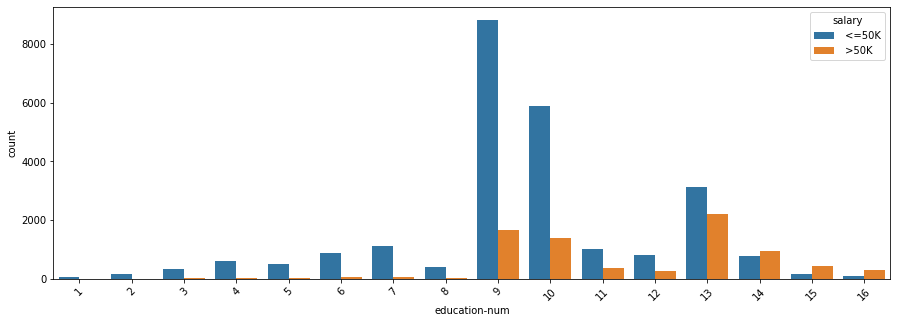

In [17]:
fig = plt.figure(figsize=(15,5))
g = sns.countplot(data = df, x='education-num', hue='salary')
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
plt.show()

# DATA PREPROCESSING

## Handeling Missing values

In [18]:
df.replace(" ?", np.nan, inplace=True)
df.fillna("other", inplace=True)

## Handeling Categorical values

In [19]:
def label_encoding(col, df):
    df[col]= LabelEncoder().fit_transform(df[col])

In [20]:
def onehotencoding(col, df):
    temp = pd.get_dummies(data = df[col], drop_first=True, prefix=f"{col}_")
    df = pd.concat([df, temp], axis=1)
    df.drop(columns=[col], axis=1, inplace=True)
    return df

In [21]:
categorical_col = ["workclass","education","marital-status", "occupation", "relationship", "race", "native-country"]
binary_col = ["sex", "salary"]

In [22]:
for col in categorical_col:
    label_encoding(col, df)
    
for col in binary_col:
    df = onehotencoding(col, df)

In [23]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,sex__ Male,salary__ >50K
0,39,6,77516,9,13,4,0,1,4,2174,0,40,38,1,0
1,50,5,83311,9,13,2,3,0,4,0,0,13,38,1,0
2,38,3,215646,11,9,0,5,1,4,0,0,40,38,1,0
3,53,3,234721,1,7,2,5,0,2,0,0,40,38,1,0
4,28,3,338409,9,13,2,9,5,2,0,0,40,4,0,0


## Age Distribution + Handeling Outlier 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='age'>

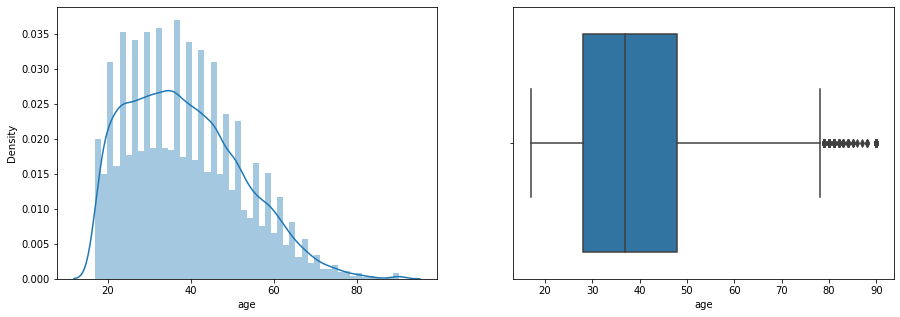

In [24]:
fig,ax = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df["age"], kde=True, ax=ax[0])
sns.boxplot(df["age"], ax=ax[1])

In [25]:
outliers = []
q1 = df["age"].quantile(0.25)
q3 = df["age"].quantile(0.75)
iqr = q3-q1

lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr
    
for value in df["age"]:
    if value > upper_bound or value < lower_bound or value <=0:
        outliers.append(value)
            
print("{} has {} outliers".format("age", len(outliers)))

age has 142 outliers


In [26]:
mn = int(df["age"].median())
   
for value in df["age"]:
    if value > upper_bound or value < lower_bound:
        df["age"] = df["age"].replace(value, mn) #(replace(current_value, new_value))

## Balancing the dataset Using SMOTE (Synthetic Minority Oversampling Technique)

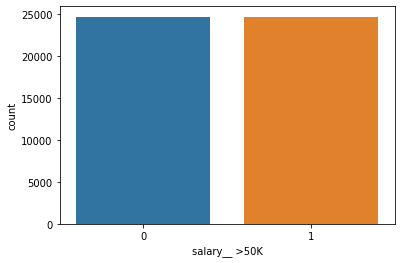

0    24698
1    24698
Name: salary__ >50K, dtype: int64


In [27]:
smote = SMOTE(random_state = 42)

X = df.drop(['salary__ >50K'],axis=1)
y = df['salary__ >50K']

X,y= smote.fit_resample(X,y)
y = pd.DataFrame({'salary__ >50K':y})
sns.countplot(data = y, x = 'salary__ >50K', y= None)
plt.show()
print(y["salary__ >50K"].value_counts())

## Spliting the dataset into Training and Testing set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((39516, 14), (9880, 14))

## Removing Constant and Quasi-constant

__Quasi-constant__: Quasi-constant features are those that show similar incentive for the incredible greater part of the dataset. In general, these features provide little, if any, information that allows a machine learning model to discriminate or predict a target. But there can be exceptions.

__Constant__: Constant features are those that show the same value, just one value, for all the observations of the dataset. In other words, the same value for all the rows of the dataset. These features provide no information that allows a machine learning model to discriminate or predict a target.

In [29]:
# Removing constant feature

cf = DropConstantFeatures(tol=1, variables=None, missing_values='raise')

cf.fit(X_train)
cf.features_to_drop_

[]

We dont have any constant features.

In [30]:
# Removing quasi-constant feature

qcf = DropConstantFeatures(tol=0.90, variables=None, missing_values='raise')
# here tol = threshold, you can set the threshold as per your requirment.

qcf.fit(X_train)
qcf.features_to_drop_

['capital-loss']

In [31]:
X_train['capital-loss'].value_counts()

0       36950
1902      248
1887      198
1977      184
1848       58
        ...  
997         1
1149        1
2013        1
1819        1
1828        1
Name: capital-loss, Length: 668, dtype: int64

So, more then 90% of the data for 'capital-loss' contains 0. Therefore we will drop it.

In [32]:
X_train = qcf.transform(X_train)
X_test = qcf.transform(X_test)

X_train.shape, X_test.shape

((39516, 13), (9880, 13))

## Feature Selection

In [33]:
sfs = SFS(RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=0), 
           k_features=10, # the more features we want, the longer it will take to run, you can play around this number and obserb the result.
           forward=True, 
           floating=False, 
           verbose=2, 
           scoring='roc_auc',
           cv=2)

sfs = sfs.fit(np.array(X_train), y_train.values.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    5.4s finished

[2022-04-25 06:22:17] Features: 1/10 -- score: 0.795121436191486[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.1s finished

[2022-04-25 06:22:21] Features: 2/10 -- score: 0.8940468385267173[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.9s finished

[2022-04-25 06:22:25] Features: 3/10 -- score: 0.9268651448841301[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [34]:
selected_feat = X_train.columns[list(sfs.k_feature_idx_)]
selected_feat

Index(['workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'capital-gain', 'native-country',
       'sex__ Male'],
      dtype='object')

# MODEL BUILDING

## Random Forest

In [35]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train[selected_feat], y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [36]:
y_pred = rf.predict(X_test[selected_feat])

## Results

In [37]:
# Accuracy Score

accuracy_score(y_test, y_pred)

0.8723684210526316

<AxesSubplot:>

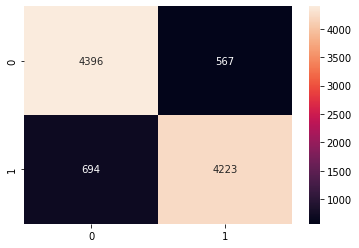

In [38]:
# Confusion matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='g')

In [39]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4963
           1       0.88      0.86      0.87      4917

    accuracy                           0.87      9880
   macro avg       0.87      0.87      0.87      9880
weighted avg       0.87      0.87      0.87      9880



## Hyperparameter tuning Random Forest

In [40]:
n_estimators=[int(x) for x in np.linspace(start=100,stop=2000,num=20)]
criterion=['gini','entropy']
max_depth=[int(x) for x in np.linspace(start=2,stop=30,num=10)]
min_samples_split=[2,5,10,15,100,1000]
min_samples_leaf=[1,2,5,10,15]
max_features=['auto','sqrt','log2']


rf_random_grid = {
    'n_estimators':n_estimators,
    'criterion':criterion,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'max_features':max_features
}

print(rf_random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 8, 11, 14, 17, 20, 23, 26, 30], 'min_samples_split': [2, 5, 10, 15, 100, 1000], 'min_samples_leaf': [1, 2, 5, 10, 15], 'max_features': ['auto', 'sqrt', 'log2']}


In [41]:
rfc = RandomForestClassifier()

rfc = RandomizedSearchCV(estimator=rfc, param_distributions=rf_random_grid, n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=1)

In [42]:
rfc.fit(X_train[selected_feat],y_train.values.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END criterion=gini, max_depth=26, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=1600; total time=  39.6s
[CV] END criterion=gini, max_depth=26, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=1600; total time=  39.2s
[CV] END criterion=gini, max_depth=26, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=1600; total time=  38.8s
[CV] END criterion=gini, max_depth=26, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=1600; total time=  39.3s
[CV] END criterion=gini, max_depth=26, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=1600; total time=  39.7s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=10

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 8, 11, 14, 17, 20,
                                                      23, 26, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15, 100,
                                                              1000],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 16

In [43]:
rfc.best_params_

{'n_estimators': 1100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'gini'}

## Results

In [44]:
# Accuracy Score

y_predict = rfc.predict(X_test[selected_feat])
accuracy_score(y_predict,y_test)

0.8758097165991903

Not much of an improvement in the accuracy, but still its good practice to do parameter tuning.

<AxesSubplot:>

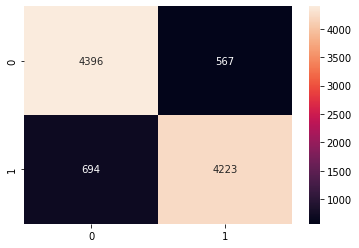

In [45]:
# Confusion Matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='g')

In [46]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4963
           1       0.88      0.86      0.87      4917

    accuracy                           0.87      9880
   macro avg       0.87      0.87      0.87      9880
weighted avg       0.87      0.87      0.87      9880

